In [192]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
# Import generic libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.io
import os, sys
import tqdm
print(os.path.expanduser('~'))

/Users/mariangelapanniello


In [194]:
# Import local tools
sys.path.append(os.path.expanduser('~/Desktop/Analysis/kohl-lab-pynalysis/'))
from pynalysis import utils

In [195]:
# Import tensortools https://github.com/ahwillia/tensortools
sys.path.append(os.path.expanduser('~/Desktop/Analysis/tensortools-master/'))
import tensortools as tt

In [196]:
# Import local OASIS installation
sys.path.append(os.path.expanduser('~/Desktop/Analysis/OASIS-master/'))
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis import oasisAR1, oasisAR2

In [197]:
# Set file-name and path to analyze
# stringid = "PVEM22.2h"
stringid = "CGCC8.5a"
#stringid = 'AIGC1.1a'
filename = os.path.expanduser('/Users/mariangelapanniello/Desktop/ca-data-large/2018/%s.mat'%stringid)

In [198]:
# Load data struct
dat = utils.load_mat_file(filename)

Not an old MAT struct. Trying to read as HDF5 for MATLAB v7.3 format instead


In [199]:
# Print contents
print("subject: %s"%stringid)
utils.print_file_content(dat)

subject: CGCC8.5a
imaging/
 date_2018_02_08
 ->area1
  ->plane1
  ->plane2
  ->session_behaviour
 ->area2
  ->plane1
  ->plane2
  ->session_behaviour
 ->area3
  ->plane1
  ->plane2
  ->session_behaviour
 ->area4
  ->plane1
  ->plane2
  ->session_behaviour
 ->area5
  ->plane1
  ->plane2
  ->session_behaviour
 date_2018_02_22
 ->area1
  ->plane1
  ->plane2
  ->session_behaviour
 ->area2
  ->plane1
  ->plane2
  ->session_behaviour
 ->area3
  ->plane1
  ->plane2
  ->session_behaviour


In [200]:
expspecifier = "date_2018_02_22/area1"
path="imaging/%s"%expspecifier
area=dat.get(path)
utils.get_hdf5group_keys(area)

['plane1', 'plane2', 'session_behaviour']

In [201]:
descriptor = "%s/%s"%(stringid,expspecifier)

In [202]:
plane1=area['plane1']
plane2=area['plane2']
sessbehav=area['session_behaviour']

In [203]:
print(plane1['fluoresence_corrected'])
print(plane2['fluoresence_corrected'])

<HDF5 dataset "fluoresence_corrected": shape (14000, 117), type "<f4">
<HDF5 dataset "fluoresence_corrected": shape (14000, 68), type "<f4">


In [204]:
print(utils.get_hdf5group_keys(sessbehav))

['ID', 'area', 'date', 'endTTL', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']


In [205]:
# Extract frame rate from struct
data = plane1
fluo = data['fluoresence_corrected']
frate = data['fRate'][0][0]
print("Frame rate %f"%frate)
print(fluo.shape)
numP1 = len(fluo[1])

Frame rate 15.025000
(14000, 117)


In [206]:
# Merge fluorescence corrected from multiple planes
planes = [plane1['fluoresence_corrected'], plane2['fluoresence_corrected']]

# Merge
fluo_raw = np.concatenate(planes,axis=1)
time = np.arange(len(fluo_raw.T))*1.0/frate

In [207]:
# Can be used to throw out oversaturated cells
idx=fluo_raw.max(1)<8000
fluo = fluo_raw[idx]
nb_frames, nb_units = fluo.shape
time = np.linspace(0,nb_frames/frate,nb_frames)
print("number of frames=%i"%nb_frames)
print("number of units=%i"%nb_units)
print(max(time))

number of frames=14000
number of units=185
931.780366057


In [208]:
sample_id = 7
plt.figure(figsize=(16,4))
p0 = plt.plot(time, fluo[:,sample_id])
#p0 = plt.plot(time, traces[:,sample_id], color='black')
p0=plt.plot(time, np.zeros(time.shape), color='black')
plt.xlabel("Time (s)")
plt.xlim(100,600)
plt.ylim(-20,2000)
sns.despine()

In [209]:
# Extract positions
tmp = []
for pos in plane1['position']:
    tmp.append(pos)
positions_plane1 = np.array(tmp).T

tmp = []
for pos in plane2['position']:
    tmp.append(pos)
positions_plane2 = np.array(tmp).T

positions_pivot = len(positions_plane1)

In [210]:
# Extract event timing
event_fields = ['motor_start', 'motor_atWhisk', 'motor_back', 'motor_atOrigin', 'stim_position']
events = {}
for f in event_fields:
    events[f] = np.array(sessbehav[f])

velocity = sessbehav['velocity']
sp = sessbehav['stim_position']

t_stim = events['motor_start']
print(sp)

<HDF5 dataset "stim_position": shape (151, 1), type "<f8">


In [211]:
sp = events["stim_position"][1]*255+events["stim_position"][0]
events["stim_position"] = sp
events["stim_position"] = np.arange(len(events["motor_atWhisk"]))
#plt.hist(sp)

In [212]:
def plot_trace(groundtruth=False):
    plt.figure(figsize=(20,4))
    plt.subplot(211)
    plt.plot(b+c, lw=2, label='denoised')
    if groundtruth:
        plt.plot(true_b+true_c, c='r', label='truth', zorder=-11)
    plt.plot(y, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    # simpleaxis(plt.gca())
    plt.subplot(212)
    plt.plot(s, lw=2, label='deconvolved', c='g')
    if groundtruth:
        for k in np.where(true_s)[0]:
            plt.plot([k,k],[-.1,1], c='r', zorder=-11, clip_on=False)
    plt.ylim(0,1.3)
    plt.legend(ncol=3, frameon=False, loc=(.02,.85));
    # simpleaxis(plt.gca())
    print("Correlation of deconvolved activity  with ground truth ('spikes') : %.4f" % np.corrcoef(s,true_s)[0,1])
    print("Correlation of denoised fluorescence with ground truth ('calcium'): %.4f" % np.corrcoef(c,true_c)[0,1])

In [213]:
# Prepare init values for OASIS
tau_d = 140e-3 #270e-3
ginit = (np.exp(-1.0/(frate*tau_d)),)
print(ginit)

(0.62163750473427448,)


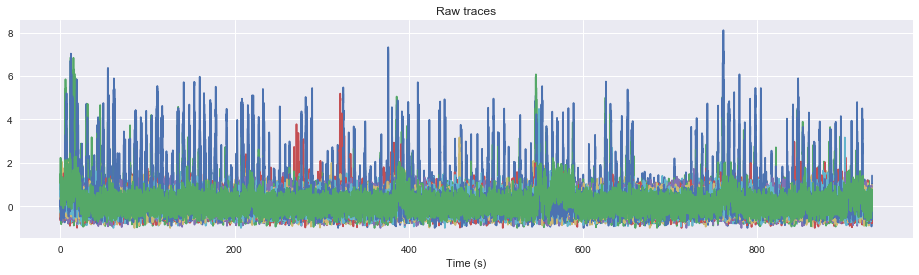

In [214]:
plt.figure(figsize=(16,4))
p0 = plt.plot(time, fluo[:,:20])
# p1 = plt.scatter(stim.running_forward*1e-3,7*np.ones(len(stim.running_forward)), color='blue', label='Running fwd.')
plt.title("Raw traces")
plt.xlabel("Time (s)")
# plt.ylim(0,1)
sns.despine()

In [215]:
# Run OASIS on each fluorescence trace
traces = []
ret_values = []
for idx in tqdm.trange(nb_units):
    y = np.array(fluo[:,idx],dtype=float)
    c, s, b, g, lam = r = deconvolve(y, g=ginit, penalty=1)
    traces.append(c)
    ret_values.append(r)
traces = np.array(traces).T

100%|██████████| 185/185 [00:04<00:00, 43.79it/s]


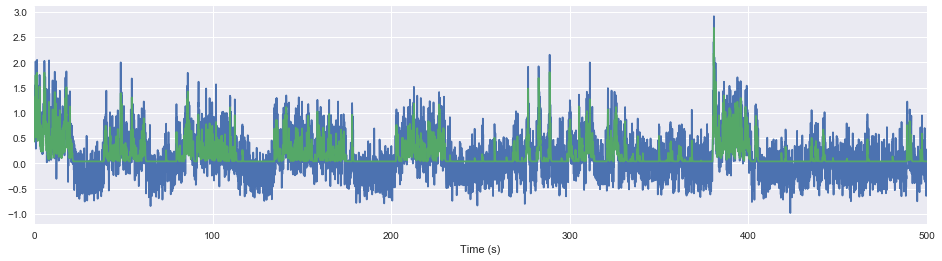

In [216]:
# Visual inspection of one denoised trace
sample_id = 4
smp = ret_values[sample_id]
plt.figure(figsize=(16,4))
p0=plt.plot(time, fluo[:,sample_id])
p0=plt.plot(time, smp[0].T+smp[2])
plt.xlabel("Time (s)")
plt.xlim(0,500)
sns.despine()

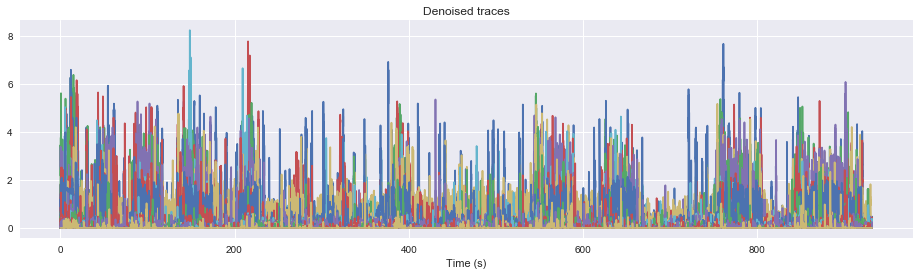

In [217]:
# Plot denoised traces
plt.figure(figsize=(16,4))
p0 = plt.plot(time, traces)
# p1 = plt.scatter(stim.running_forward*1e-3,7*np.ones(len(stim.running_forward)), color='blue', label='Running fwd.')
plt.xlabel("Time (s)")
plt.title("Denoised traces")
sns.despine()

# A look at effective data dimension with PCA

In [218]:
from sklearn.decomposition import PCA, NMF
nb_components = 20

In [219]:
X = traces

pca = PCA()
pca.fit(X)
varexp_denoised = np.cumsum(pca.explained_variance_ratio_)

In [220]:
X = np.array(fluo.T)
# time = np.arange(len(X))*1.0/frate
pca = PCA()
pca.fit(X)
varexp_raw = np.cumsum(pca.explained_variance_ratio_)

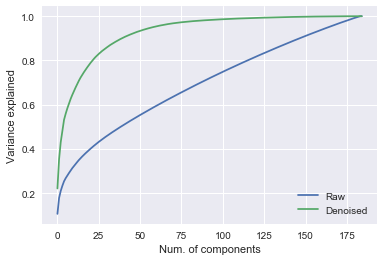

In [221]:
ax=plt.plot(varexp_raw, label="Raw")
ax=plt.plot(varexp_denoised, label="Denoised")
plt.xlabel("Num. of components")
plt.ylabel("Variance explained")
plt.legend()

# Non-negative matrix factorization

In [222]:
# Perform NMF on all data
X = traces-traces.min() # make sure all data is positive
nb_components = 20
nmf = NMF(n_components=nb_components, random_state=1, alpha=0.1, l1_ratio=0.5)
nmf.fit(X)

NMF(alpha=0.1, beta=1, eta=0.1, init=None, l1_ratio=0.5, max_iter=200,
  n_components=20, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [223]:
# Transform data
nmf_tarnsformed = nmf.transform(traces)

In [224]:
def plot_events(ev_names, y_offset=1.0, y_scale=0.1):
    cols = ["black", "gray", "darkblue", "darkred", "darkgreen"]
    for i,label in enumerate(event_fields):
        t_event = events[label]/frate
        y = (y_offset + y_scale*i)*np.ones(t_event.shape)
        plt.scatter(t_event,y,c=cols[i],label=label)
        

In [225]:
def plot_color_events(ev_name, col_name, y_offset=2.0, y_scale=0.1):
    #cols = ["black", "gray", "darkblue", "darkred", "darkgreen"]
    for i,label in enumerate(event_fields):
        t_event = events[ev_name]/frate
        col = events[col_name]
        y = (y_offset + y_scale)*np.ones(t_event.shape)
        plt.scatter(t_event,y,c=col,label=ev_name,cmap=plt.cm.hot)

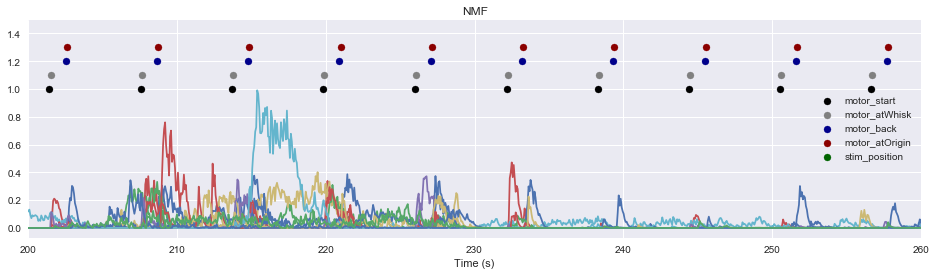

In [226]:
plt.figure(figsize=(16,4))
p0 = plt.plot(time, nmf_tarnsformed[:,:nb_components])
plot_events(event_fields)
plt.title("NMF")
plt.xlabel("Time (s)")
plt.legend(loc='best')
plt.xlim((200,260))
sns.despine()

In [227]:
speed = sessbehav['stim_speed']
print(speed[1])

[ 840.]


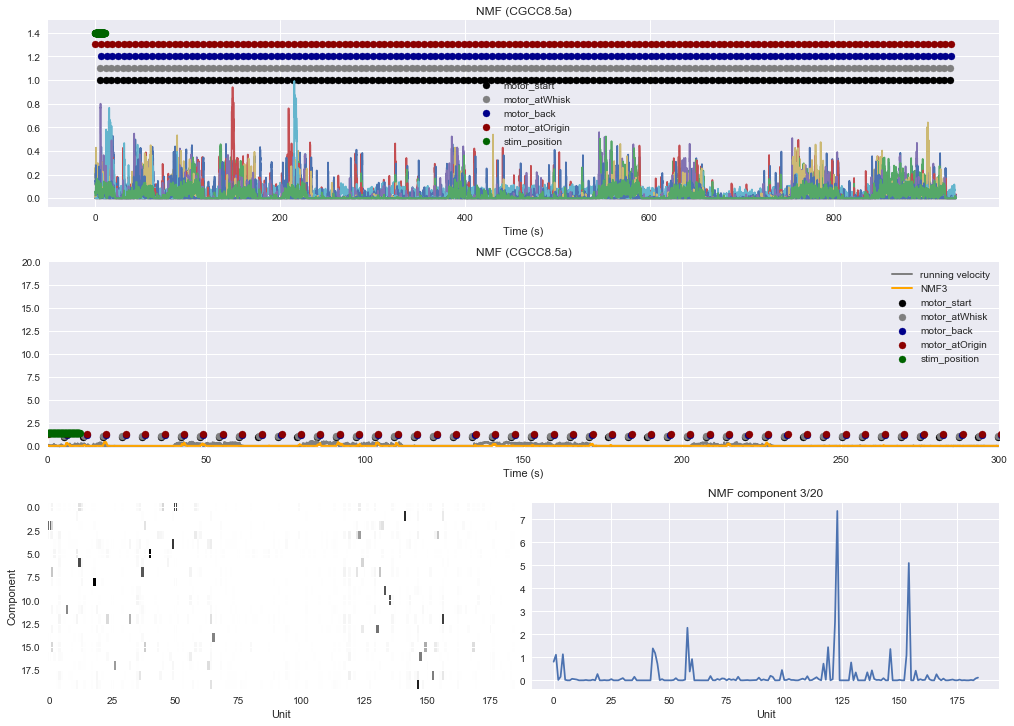

In [228]:
plt.figure(figsize=(14,10))

plt.subplot(3,1,1)
p0 = plt.plot(time, nmf_tarnsformed[:,:nb_components])
plot_events(event_fields)
plt.xlabel("Time (s)")
sns.despine()
plt.title("NMF (%s)"%stringid)
plt.legend()
#plt.xlim((200,320))

compid = 3
plt.subplot(3,1,2)
plot_events(event_fields,1,0.1)
plt.plot(time[0:len(np.squeeze(velocity))], -np.squeeze(velocity)/ 1000,  c='gray', linewidth=2,label = 'running velocity')
p0 = plt.plot(time, nmf_tarnsformed[:,compid], c='orange', linewidth=2, label="NMF%i"%(compid))
plot_color_events=("motor_atWhisk","stim_position")
plt.xlabel("Time (s)")
sns.despine()
plt.title("NMF (%s)"%stringid)
plt.legend()
plt.xlim(0,300)
plt.ylim(-0.2,20)

plt.subplot(3,2,5)
plt.tight_layout()
plt.imshow(nmf.components_,aspect="auto")
plt.xlabel("Unit")
plt.ylabel("Component")


plt.subplot(3,2,6)
plt.plot(nmf.components_[compid])
plt.xlabel("Unit")
plt.title("NMF component %i/%i"%(compid,nb_components))
sns.despine()

Not an old MAT struct. Trying to read as HDF5 for MATLAB v7.3 format instead
subject: CGCC8.5a
<HDF5 group "/tuning" (1 members)>
tuning/
 date_2018_02_22
 ->area1
  ->plane1
  ->plane2
 ->area2
  ->plane1
  ->plane2


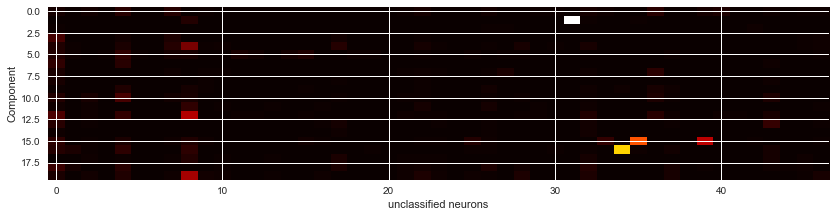

In [229]:
tuningcurve = os.path.expanduser('/Users/mariangelapanniello/Dropbox/K_lab/Analysis/neuron categories/tuning_data/%stuning.mat' %stringid)
#tuningcurve = os.path.expanduser('/Users/mariangelapanniello/Dropbox/K_lab/Analysis/ca-data-large/%s.mat'%stringid)

dat_tuning = utils.load_mat_file(tuningcurve)

print("subject: %s"%stringid)

datatuning = dat_tuning['tuning']
import pprint
pprint.pprint(datatuning)

print("tuning/")
for sess in datatuning:
    print(" %s"%sess)
    for area in datatuning[sess]:
        print(" ->%s"%area)
        for plane in datatuning[sess][area]:
            print("  ->%s"%plane)
            
expspecifier = "date_2018_02_22/area1"
path="tuning/%s"%expspecifier
area_tun=dat_tuning.get(path)
utils.get_hdf5group_keys(area_tun)

descriptor = "%s/%s"%(stringid,expspecifier)

plane_1=area_tun['plane1']
plane_2=area_tun['plane2']

#print(plane1['categories'])
#print(plane2['categories'])

plot_planes = [plane_1['categories'], plane_2['categories']]

plot_planes = np.concatenate(plot_planes,axis=0)
# print (plot_planes)
#len(plot_planes)

ones = np.where(plot_planes==1)[0] #monotonic preference anterior
twos = np.where(plot_planes==2)[0] #monotonic preference posterior
threes = np.where(plot_planes==3)[0] #single peaked
zeroes = np.where(plot_planes==0)[0] #unclassified

#len(ones)
#print(ones)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.imshow(nmf.components_[:,ones],aspect="auto", cmap='hot')
plt.xlabel("monotonic neurons")
plt.ylabel("Component")

plt.subplot(1,3,2)
plt.imshow(nmf.components_[:,twos],aspect="auto", cmap='hot')
plt.xlabel("monotonic neurons")
plt.ylabel("Component")

plt.subplot(1,3,3)
plt.imshow(nmf.components_[:,threes],aspect="auto", cmap='hot')
plt.xlabel("peaked neurons")
plt.ylabel("Component")

plt.figure(figsize=(14,7))
plt.subplot(2,1,1)
plt.imshow(nmf.components_[:,zeroes],aspect="auto", cmap='hot')
plt.xlabel("unclassified neurons")
plt.ylabel("Component")

In [230]:
plt.figure(figsize=(20,5))
compid =3

plt.plot(time, nmf_tarnsformed[:,compid], c='orange', linewidth=2, label="NMF%i"%(compid))
plt.xlabel("Time (s)")
sns.despine()
plt.legend()

#len(np.squeeze(velocity))


# Perform CP decomposition

In [231]:
# seed for random number generator
random_state = 12345

In [232]:
# Create tensorized data from data matrix by chopping up the recording around the motor start events 
window_size = int(frate*4) # in frames
cellids = list(range(nb_units)) # select all cells
#activity = traces
activity = fluo
slices = np.zeros((window_size, nb_units))
print(len(events['motor_start']))
for frame in events['motor_start'].ravel():
   
    fr = int(frame)

    if fr<window_size//2 or fr>=activity.shape[0]-window_size//2: continue   
    s = activity[fr-window_size//2:fr+window_size//2, cellids]
    s = np.array(s)
    #print(s.shape)
    slices = np.dstack((slices,s))
    
    

dt=np.array(slices[:,:,:-1])
dt1 = np.swapaxes(dt,1,2)
datatensor = np.swapaxes(dt1,0,1)
print(dt.shape)
print(datatensor.shape)

151
(60, 185, 151)
(151, 60, 185)


In [233]:
# Show tensor shapes (nb trials x frames x unit)
# split into planes
p1 = datatensor[:,:,0:numP1]
p2 = datatensor[:,:,numP1+1:]

print(p1.shape)
print(p2.shape)
print(datatensor.shape)


(151, 60, 117)
(151, 60, 67)
(151, 60, 185)


In [149]:
# Fits models for increasing number of rank using Alex' code from the Ganguli Lab
# We do 10 replicates for each fit because tensor decomposition is not a unique problem
als_results_p1 = tt.fit_ensemble(p1, range(1,20), nonneg=True, replicates=10, tol=1e-6)
als_results_p2 = tt.fit_ensemble(p2, range(1,20), nonneg=True, replicates=10, tol=1e-6)

Optimizing rank-1 models.
   10/10 converged, min error = 0.8914, max error = 0.8914, mean error = 0.8914, time to fit = 2.4097s
Optimizing rank-2 models.
   10/10 converged, min error = 0.8599, max error = 0.8599, mean error = 0.8599, time to fit = 6.7905s
Optimizing rank-3 models.
   10/10 converged, min error = 0.8394, max error = 0.8433, mean error = 0.8402, time to fit = 5.7999s
Optimizing rank-4 models.
   10/10 converged, min error = 0.8233, max error = 0.8407, mean error = 0.8271, time to fit = 7.4893s
Optimizing rank-5 models.
   10/10 converged, min error = 0.8142, max error = 0.8145, mean error = 0.8143, time to fit = 7.6874s
Optimizing rank-6 models.
   10/10 converged, min error = 0.8061, max error = 0.8115, mean error = 0.8077, time to fit = 6.4167s
Optimizing rank-7 models.
   10/10 converged, min error = 0.8028, max error = 0.8045, mean error = 0.8032, time to fit = 11.4621s
Optimizing rank-8 models.
   10/10 converged, min error = 0.7995, max error = 0.8019, mean error

In [150]:
line_kw1 = {
    'color': 'r',
    'alpha': 0.7,
    'lw': 4,
    'zorder': -1
}
scatter_kw = {
    'color': 'k',
    'alpha': 0.7,
}
line_kw2 = {
    'color': 'b',
    'alpha': 0.7,
    'lw': 4,
    'zorder': -1
}
sns.set()
plt.figure(figsize=(8,5))

p1 = tt.plot_error(als_results_p1,
              jitter=.4,
              line_kw=line_kw1,
              scatter_kw=scatter_kw)
p1.legend(['plane1'], loc = 0, fontsize = '20')



p2 = tt.plot_error(als_results_p2,
              jitter=.4,
              line_kw=line_kw2,
              scatter_kw=scatter_kw)

plt.title('varience explained')


sns.despine()

In [151]:
# Select rank of model to plot below
cp_rank = 5
factors_p1 = als_results_p1[cp_rank]['factors'][0]
factors_p2 = als_results_p2[cp_rank]['factors'][0]
                                        
a1 = factors_p1[0]
a2 = factors_p2[0]

In [152]:
# shape should be trial x rank
print(a1.shape)
print(a2.shape)


(151, 5)
(151, 5)


In [153]:
p0=plt.plot(a1[:,0])
p1=plt.plot(a2[:,0])

plt.xlabel("Trial")


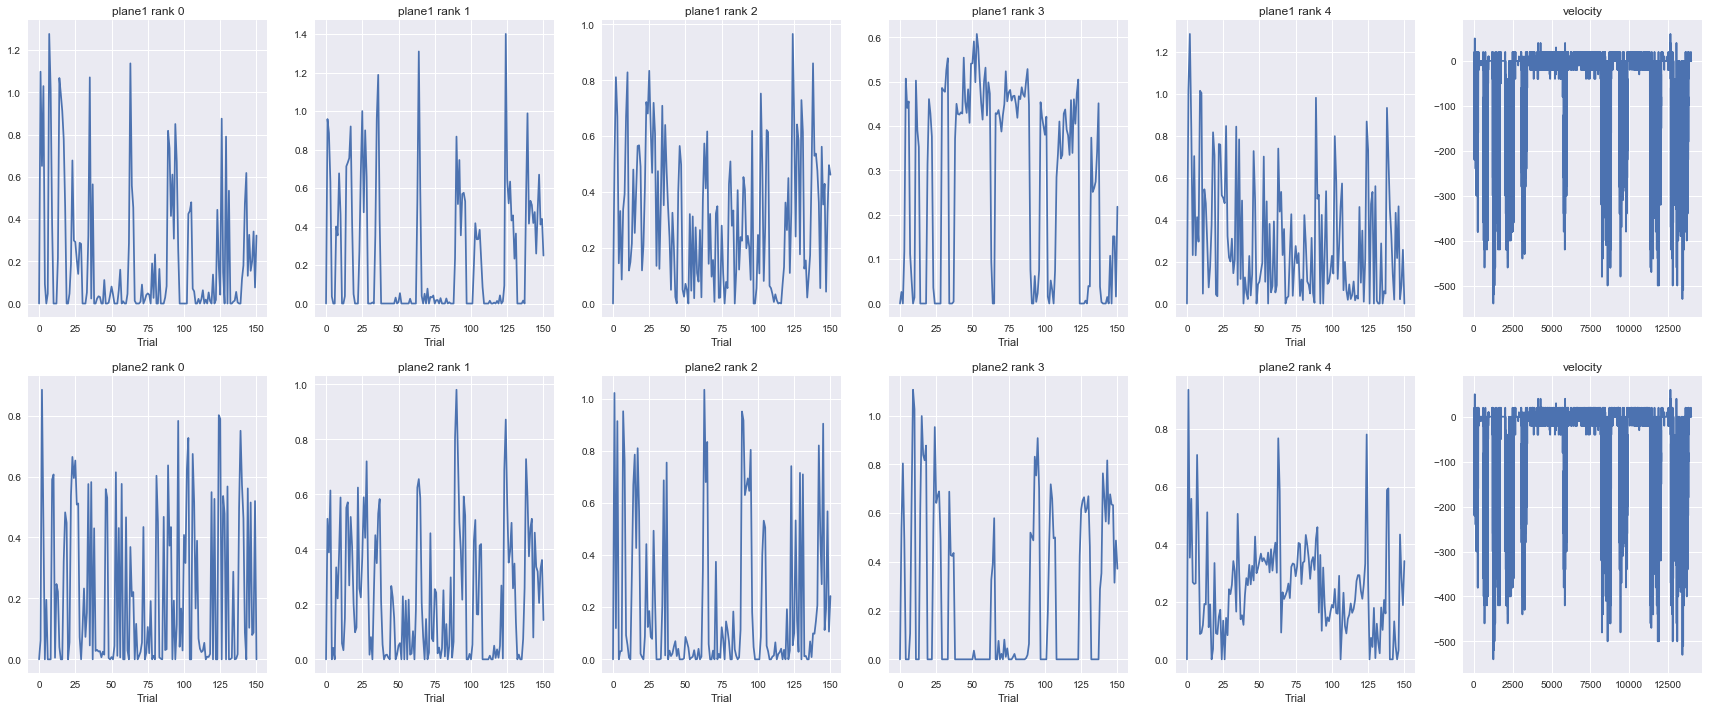

In [154]:
sns.set()
plt.figure(figsize=(30,12))

for i in range(cp_rank):
    ax=plt.subplot(2,6,i+1)
    p0=plt.plot(a1[:,i])
    plt.xlabel("Trial")
    plt.title('plane1 rank %s' %i)
    
    
for i in range(cp_rank):
    ax=plt.subplot(2,6,i+2+cp_rank)
    p0=plt.plot(a2[:,i])
    plt.xlabel("Trial")
    plt.title('plane2 rank %s' %i)
    
for i in range(2):
    ax = plt.subplot(2,6,6*(i+1))
    p0 = plt.plot(np.squeeze(velocity))
    plt.title('velocity')
    


In [155]:
b1 = factors_p1[1]
b2 = factors_p2[1]
trialtime = np.arange(-datatensor.shape[1]//2,datatensor.shape[1]//2)/frate


In [156]:
b1.shape

(60, 5)

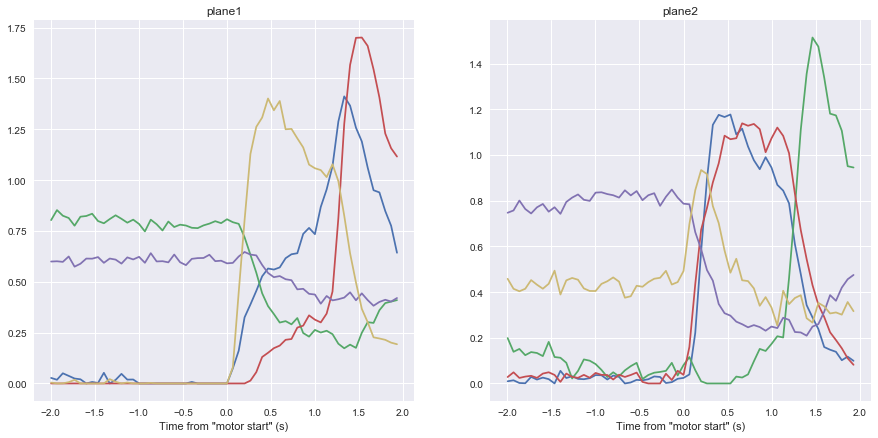

In [157]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
p0=plt.plot(trialtime,b1)
    
plt.xlabel('Time from "motor start" (s)')
plt.title('plane1')

plt.subplot(1,2,2)
p1=plt.plot(trialtime,b2)
plt.xlabel('Time from "motor start" (s)')
plt.title('plane2')


sns.despine()

In [158]:
plt.figure(figsize=(16,6))
for i in range(cp_rank):

    ax=plt.subplot(2,5,i+1)
    p0=plt.plot(trialtime,b[:,i])
plt.xlabel('Time from "motor start" (s)')

TypeError: 'float' object is not subscriptable

In [ ]:
c=factors[2]
print(c.shape)
p0=plt.plot(c[:,0])
plt.xlabel("Unit")

In [ ]:
plt.figure(figsize=(16,6))
for i in range(cp_rank):
    ax=plt.subplot(2,5,i+1)
    p0=plt.plot(c[:,i])
plt.xlabel('Unit')